In [1]:
# For colab
# wget -nc 140.114.76.113:8000/pA1.csv
# wget -nc 140.114.76.113:8000/pA2.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [4]:
seed = 999
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Set up variables
batch_size = 1
# test_split = .3
shuffle_dataset = False

In [6]:
class Data(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor(ann['x'])
        y = torch.tensor(ann['y'])
        return x, y

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(1) * 0.001)
        self.b = nn.Parameter(torch.rand(1) * 0.001)
    
    def forward(self, xs):
        ps = self.a * xs + self.b
        return ps

In [8]:
# Load dataset
data = Data('./pA1.csv')
dataloader = DataLoader(data, batch_size=batch_size)

# # Create data indices for training, test
# data_size = len(data)
# indices = list(range(data_size))
# split_t = int(np.floor(test_split * data_size))

# # Split the dataset as follow
# # | test | train |
# test_indices, train_indices = indices[:split_t], indices[split_t:]

# # Create data sampler
# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

# # Create dataloader
# trainloader = DataLoader(data, batch_size=batch_size,
#                          sampler=train_sampler)
# testloader = DataLoader(data, batch_size=batch_size,
#                         sampler=test_sampler)

In [9]:
# For plotting
scatter_x = []
scatter_y = []
for i in data:
    scatter_x.append(i[0])
    scatter_y.append(i[1])
scatter_x = np.asarray(scatter_x)
scatter_y = np.asarray(scatter_y)

In [10]:
# device = 'cpu'
model = Net().to(device)
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

0%--------------------100%
 |--------------------|
Finish Training!
y = 5.029x + 3.983


Text(0, 0.5, 'loss')

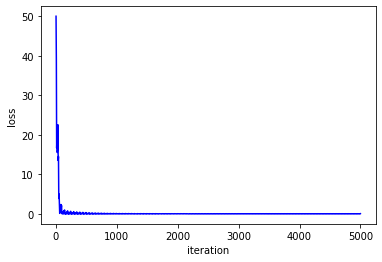

In [12]:
show_iter = 50
# EPOCH = 2000
EPOCH = 100
# show_epoch = 50
show_epoch = 5

history = {
    'loss': [],
    'a': [],
    'b': []
}

loss_plot = {
    'iter': [],
    'loss': []
}

# Plot progress bar
print('0%', end='')
for i in range(int(EPOCH/show_epoch)):
    print('-', end='')
print('100%')
print(' |', end='')

i=0
for epoch in range(EPOCH):
    for xs, ys in iter(dataloader):
        i+=1
        xs = xs.to(device)
        ys = ys.to(device)

        optimizer.zero_grad()
        ps = model(xs)
        loss = criterion(ps, ys)
        loss.backward()
        optimizer.step()
        
        if i % show_epoch == (show_epoch-1):
            history['loss'].append(loss.detach().item())
            history['a'].append(model.a.item())
            history['b'].append(model.b.item())
        
            loss_plot['iter'].append(i)
            loss_plot['loss'].append(loss.detach().item())
    
    if epoch % show_epoch == (show_epoch-1):
        print('-',end='')
#         print('[%d] loss: %.3f, a: %.3f, b: %.3f' %
#             (epoch+1, loss.detach().item(),
#              model.a.item(), model.b.item()))


print("|\nFinish Training!")
print("y = %.3fx + %.3f" % (model.a, model.b))
plt.plot(np.array(loss_plot['iter']),
         np.array(loss_plot['loss']), 'b')
plt.xlabel("iteration")
plt.ylabel("loss")

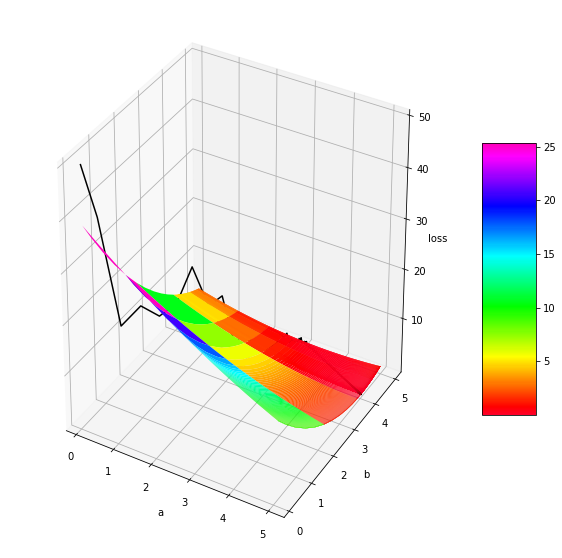

In [13]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

plot_x = np.array(history['a'])
plot_y = np.array(history['b'])
plot_z = np.array(history['loss'])
ax.plot3D(plot_x, plot_y, plot_z, c='black')

surface_x, surface_y = np.meshgrid(plot_x, plot_y)
# surface_x = torch.tensor(surface_x).to(device)
# surface_y = torch.tensor(surface_y).to(device)

F = np.zeros((surface_x.shape[0], surface_y.shape[1]))
for x, y in iter(dataloader):
    x = np.array(x)
    y = np.array(y)
#     x = x.double().to(device)
#     y = np.full((surface_x.shape[0], surface_y.shape[1]), y)
#     y = torch.tensor(y).double().to(device)
    y_p = surface_x*x+surface_y
    loss = ((y_p-y)**2)
#     F += np.array(loss.cpu())
    F += loss
F = F / len(dataloader)

# surface_x = surface_x.cpu()
# surface_y = surface_y.cpu()
surf = ax.plot_surface(surface_x, surface_y, F, rstride=5,
                       cstride=5, cmap=plt.get_cmap('gist_rainbow'))

# rotate the axes and update
# ax.view_init(30, 335)

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("loss")
fig.colorbar(surf, shrink=0.5, aspect=5)

Text(0, 0.5, 'y')

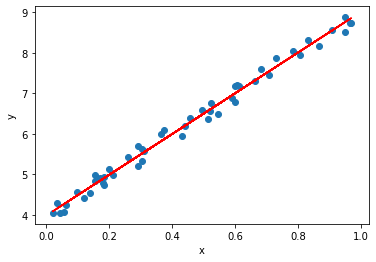

In [14]:
a = model.a.detach().cpu().numpy()
b = model.b.detach().cpu().numpy()
plt.scatter(scatter_x, scatter_y)
plt.plot(scatter_x, (a*scatter_x+b), 'r-')
plt.xlabel("x")
plt.ylabel("y")

In [15]:
# with torch.no_grad():
#     batch_count = 0
#     running_loss = 0
#     for xs, ys in iter(testloader):
#         xs = xs.to(device)
#         ys = ys.to(device)
        
#         ps = model(xs)
#         loss = criterion(ps, ys)
        
#         running_loss += loss.detach().item()
        
#         batch_count+=1
#         print('[batch: %d] loss: %.3f' %
#                  (batch_count, loss.detach().item()))        
        
#     print("loss: %.3f" % (running_loss/batch_count))

In [16]:
# Reference:
# https://stackoverflow.com/questions/55920015/how-to-realize-a-polynomial-regression-in-pytorch-python

In [17]:
class Data2(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor([ann['x']**2, ann['x']])
        y = torch.tensor(ann['y'])
        return x, y

In [18]:
class Net2(nn.Module):
    def __init__(self, feature_in, feature_out):
        super().__init__()
        self.L1 = nn.Linear(feature_in, feature_out, bias=True)
    
    def forward(self, xs):
        xs = self.L1(xs)
        return xs

In [19]:
# Load dataset
data2 = Data2('./pA2.csv')
dataloader2 = DataLoader(data2, batch_size=batch_size)

# # Create data indices for training, test
# data2_size = len(data2)
# indices = list(range(data2_size))
# split_t = int(np.floor(test_split * data2_size))

# # Split the dataset as follow
# # | test | train |
# test_indices, train_indices = indices[:split_t], indices[split_t:]

# # Create data sampler
# train_sampler2 = SubsetRandomSampler(train_indices)
# test_sampler2 = SubsetRandomSampler(test_indices)

# # Create dataloader
# trainloader2 = DataLoader(data2, batch_size=batch_size,
#                          sampler=train_sampler2)
# testloader2 = DataLoader(data2, batch_size=batch_size,
#                         sampler=test_sampler2)

In [20]:
# For plotting
x2 = []
y2 = []
for i in data2:
    x2.append(i[0][1])
    y2.append(i[1])
x2 = np.asarray(x2)
y2 = np.asarray(y2)

In [21]:
model2 = Net2(2, 1).to(device)

In [22]:
criterion = nn.MSELoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.03, momentum=0.9)

0%------------100%
 |------------|
Finish Training!


Text(0, 0.5, 'loss')

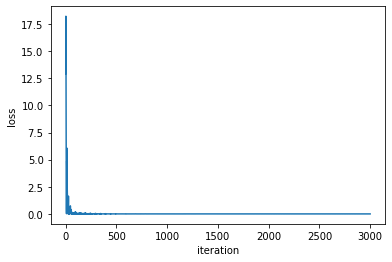

In [23]:
EPOCH = 60
show_epoch = 5

Plot = {
    'iter':[],
    'loss':[]
}

# Plot progress bar
print('0%', end='')
for i in range(int(EPOCH/show_epoch)):
    print('-', end='')
print('100%')
print(' |', end='')

iter_count = 0
for epoch in range(EPOCH):
    for xs, ys in iter(dataloader2):
        iter_count += 1
        xs = xs.to(device)
        ys = ys.to(device)
        
        optimizer2.zero_grad()
        ps = model2(xs)
        loss = criterion(ps, ys)
        loss.backward()
        optimizer2.step()
        
        Plot['iter'].append(iter_count)
        Plot['loss'].append(loss.detach().item())
            
    if epoch % show_epoch == (show_epoch-1):
        print('-',end='')

print("|\nFinish Training!")

plt.plot(np.array(Plot['iter']), np.array(Plot['loss']))
plt.xlabel("iteration")
plt.ylabel("loss")

In [24]:
# with torch.no_grad():
#     batch_count = 0
#     running_loss = 0
#     for xs, xy in iter(testloader2):
#         xs = xs.to(device)
#         ys = ys.to(device)
        
#         ps = model2(xs)
#         loss = criterion(ps, ys)
        
#         running_loss += loss.detach().item()
        
#         batch_count+=1
#         print('[batch: %d] loss: %.3f' %
#                  (batch_count, loss.detach().item()))        
        
#     print("loss: %.3f" % (running_loss/batch_count))

In [25]:
w0 = model2.L1.weight[0][0].detach().cpu().item()
w1 = model2.L1.weight[0][1].detach().cpu().item()
w2 = model2.L1.bias[0].detach().cpu().item()
print("y = %.3fx^2 + %.3fx + %.3f2" % (w0, w1, w2))

y = -1.991x^2 + 0.964x + 4.0042


Text(0, 0.5, 'y')

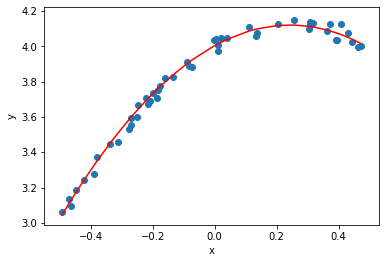

In [26]:
plt.scatter(x2, y2)
x_sort = np.sort(x2)
py = (w0 * (x_sort**2) + w1 * x_sort + w2)
plt.plot(x_sort, py, 'r-')
plt.xlabel("x")
plt.ylabel("y")